# Clasificación de imágenes con CNN: ¿Perro o gato?

### **Carga y comprobación de datos**

Tenemos un archivo ZIP, comenzamos extrayéndolo y metiendo los datos en una carpeta data:

In [2]:
import zipfile
import os

zip_path = "dogs-vs-cats.zip"
extract_path = "data"

# Descomprimimos el zip principal
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraído:", os.listdir(extract_path))

Extraído: ['sampleSubmission.csv', 'test1', 'test1.zip', 'train', 'train.zip']


Dentro habían 2 zips, por lo que volvemos a extraer estas carpetas y ya tendremos las imágenes

In [2]:
# Descomprimimos train.zip
with zipfile.ZipFile(os.path.join(extract_path, "train.zip"), "r") as zip_ref:
    zip_ref.extractall(os.path.join(extract_path, "train"))

# Descomprimimos test1.zip
with zipfile.ZipFile(os.path.join(extract_path, "test1.zip"), "r") as zip_ref:
    zip_ref.extractall(os.path.join(extract_path, "test1"))

Listo, meteremos las imágenes en un dataframe para tratarlas más facilmente y veremos cuántas tenemos:

In [3]:
import pandas as pd

filenames = os.listdir("data/train/train") # Listamos todos los nombres de los archivos

categories = []
for filename in filenames:
    category = filename.split('.')[0]  # dog.1.jpg -> dog
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

# Crear DataFrame
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Mostrar resultados
print(f"Total de imágenes: {len(df)}")
print(f"Perros (1): {len(df[df['category'] == 1])}")
print(f"Gatos (0): {len(df[df['category'] == 0])}")

Total de imágenes: 25000
Perros (1): 12500
Gatos (0): 12500


Ya tenemos creado el dataframe con los nombres de los archivos y su categoria (0: gato, 1: perro). Con esto podremos manejar más fácilmente las imágenes

In [4]:
df.sample(5)

,filename,category
20482,dog.5932.jpg,1
4172,cat.2502.jpg,0
20204,dog.5682.jpg,1
18522,dog.4168.jpg,1
10683,cat.8363.jpg,0


Ahora vamos a ver ejemplos de las imágenes:

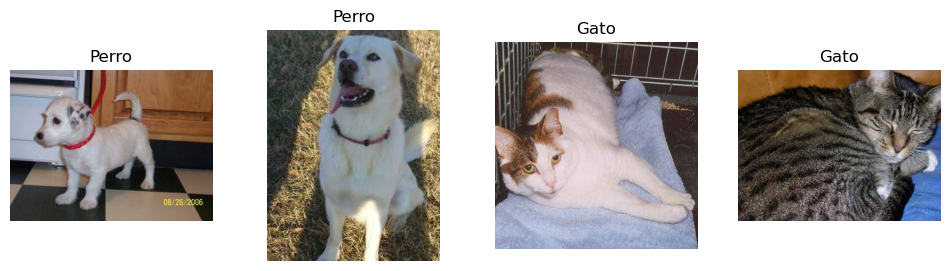

In [5]:
import matplotlib.pyplot as plt
import cv2

# Ver 4 imágenes: 2 perros y 2 gatos
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# perros
dog_files = df[df['category'] == 1]['filename'].sample(2)
for i, filename in enumerate(dog_files):
    img = cv2.imread(f"data/train/train/{filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #CV2 lee en BGR, lopasamos a RGB por matplotlib
    axes[i].imshow(img)
    axes[i].set_title("Perro")
    axes[i].axis('off')

# gatos  
cat_files = df[df['category'] == 0]['filename'].sample(2)
for i, filename in enumerate(cat_files):
    img = cv2.imread(f"data/train/train/{filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i+2].imshow(img)
    axes[i+2].set_title("Gato")
    axes[i+2].axis('off')

plt.show()

En este punto, ya hemos cargado y comprobado todo, podemos comenzar el preprocesamiento

### **Preprocesamiento**

Las redes convolucionales (CNN) requieren que todas las imágenes tengan el mismo tamaño de entrada, por lo que el primer paso fundamental es redimensionarlas.

A mayor tamaño, más calidad visual y detalle se conserva, pero también mayor coste computacional: más memoria, más tiempo de entrenamiento y riesgo de sobreajuste. Por eso, es importante encontrar un equilibrio.

Para ello, he visualizado varias imágenes de perros y gatos en diferentes resoluciones (64×64, ..., 224×224).
Esto me permite observar a partir de qué resolución se mantienen los rasgos clave (como orejas, ojos, forma del cuerpo) sin perder excesiva calidad, optimizando así rendimiento y eficiencia.

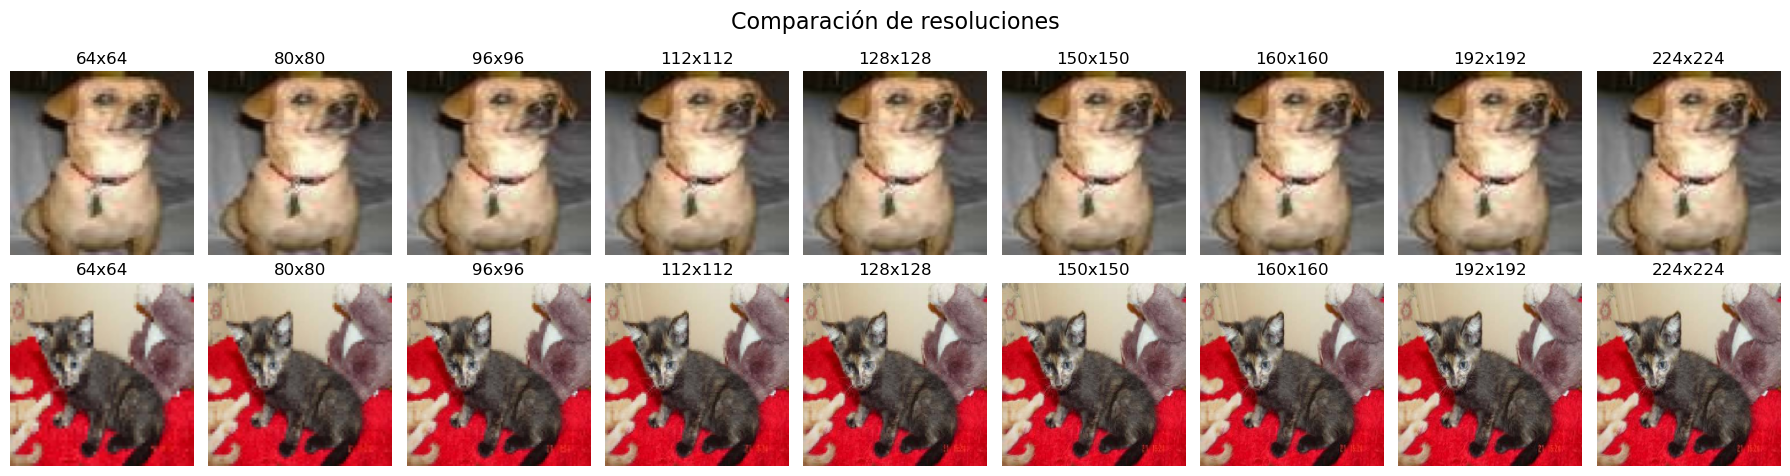

In [6]:
# Tamaños a probar
sizes = [64, 80, 96, 112, 128, 150, 160, 192, 224]

# Seleccionar una imagen de perro y una de gato
dog_filename = df[df['category'] == 1]['filename'].sample(1).values[0]
cat_filename = df[df['category'] == 0]['filename'].sample(1).values[0]

# Leer y convertir imágenes a RGB
dog_img = cv2.imread(os.path.join("data/train/train", dog_filename))
dog_img = cv2.cvtColor(dog_img, cv2.COLOR_BGR2RGB)

cat_img = cv2.imread(os.path.join("data/train/train", cat_filename))
cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)

# Crear la figura
fig, axes = plt.subplots(2, len(sizes), figsize=(18, 5))

for i, size in enumerate(sizes):
    # Redimensionar imágenes
    resized_dog = cv2.resize(dog_img, (size, size))
    resized_cat = cv2.resize(cat_img, (size, size))
    
    # Mostrar perro
    axes[0, i].imshow(resized_dog)
    axes[0, i].set_title(f"{size}x{size}")
    axes[0, i].axis('off')
    
    # Mostrar gato
    axes[1, i].imshow(resized_cat)
    axes[1, i].set_title(f"{size}x{size}")
    axes[1, i].axis('off')

plt.suptitle("Comparación de resoluciones", fontsize=16)
plt.tight_layout()
plt.show()


Después de ejecutar varias pruebas visualizando imágenes a distintas resoluciones, he observado que una resolución de 112x112 píxeles ofrece un buen equilibrio:
captura suficientemente bien los detalles importantes (como ojos, orejas y forma general) sin ser demasiado grande en términos de carga computacional, por lo que las imágenes serán redimensionadas a ese tamaño.

Ahora pasaremos a dividir el conjunto de datos en entrenamiento y validación.

Esto es importante para poder evaluar el rendimiento real del modelo durante el entrenamiento, evitando sobreajustes. Usaremos una proporción común, como el 80% para entrenamiento y el 20% para validación.

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['category']  # Usar la columna category del DataFrame
)

# Reset index para evitar problemas
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print(f"Train: {len(df_train)} imágenes")
print(f"Validation: {len(df_val)} imágenes")
print(f"Train - Perros: {sum(df_train['category'])} | Gatos: {len(df_train) - sum(df_train['category'])}")
print(f"Val - Perros: {sum(df_val['category'])} | Gatos: {len(df_val) - sum(df_val['category'])}")

Train: 20000 imágenes
Validation: 5000 imágenes
Train - Perros: 10000 | Gatos: 10000
Val - Perros: 2500 | Gatos: 2500


Para manejar este dataset, donde cargar todas las imágenes en memoria al mismo tiempo no es práctico o incluso imposible, utilizaremos un generador de datos que carga y procesa las imágenes en pequeños lotes o batches.

El generador:
- Carga solo un batch (grupo) de imágenes a la vez, evitando saturar la memoria RAM.

- Permite alimentar el modelo con datos de forma eficiente durante el entrenamiento.

- Realiza mezcla aleatoria (shuffle) de los datos en cada epoch para mejorar la generalización del modelo.

- Normaliza y preprocesa las imágenes justo antes de pasarlas al modelo.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Las categorías sean tipo string (requerido por flow_from_dataframe)
df_train_str = df_train.copy()
df_val_str = df_val.copy()

# Mapear 0->dog, 1->cat (o viceversa según tu dataset)
# Ajusta este mapeo según corresponda a tu dataset
label_map = {0: 'cat', 1: 'dog'}  
df_train_str['category'] = df_train_str['category'].map(label_map)
df_val_str['category'] = df_val_str['category'].map(label_map)

# 2. Crear el generador de entrenamiento
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_str,
    directory="data/train/train",     # carpeta donde están las imágenes
    x_col="filename",                 # columna con nombres de archivo
    y_col="category",                 # columna con etiquetas
    target_size=(112, 112),           # resize automático
    batch_size=32,
    class_mode="binary",              # es clasificación binaria
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val_str,
    directory='data/train/train',
    x_col='filename',
    y_col='category',
    target_size=(112, 112),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # mejor no mezclar en validación
)

# 3. Obtener un batch de prueba
X_batch, y_batch = next(train_generator)

print(f"Shape del batch: {X_batch.shape}")
print(f"Labels: {y_batch}")

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Shape del batch: (32, 112, 112, 3)
Labels: [1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 1.]


### **Arquitectura de la red**

Comenzaremos con una red sencilla pero funcional, con el objetivo de obtener resultados preliminares y luego iterar gradualmente para optimizar el rendimiento y el uso de memoria.

La red incluirá:

- 3 bloques convolucionales con filtros que van desde 16 hasta 64, usando kernels de 3x3.

- Batch Normalization después de cada convolución, para:

    - Estabilizar el entrenamiento al normalizar las activaciones (media=0, desviación estándar=1).

    - Permitir tasas de aprendizaje más altas.

    - Acelerar la convergencia (hasta 3–5 veces más rápido).

    - Actuar como regularizador natural, reduciendo el overfitting.

En la parte final de la red (fully connected), usaremos:

- 2 capas densas: una con 64 neuronas y la salida final con 1 neurona (para clasificación binaria).

Con esta configuración inicial, probaremos el rendimiento del modelo. En base a los resultados, evaluaremos si conviene añadir mejoras como Dropout, Data Augmentation o más capas.

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam


model = Sequential()

# Bloque 1: 16 filtros
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(112, 112, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Bloque 2: 32 filtros
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Bloque 3: 64 filtros
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Aplanar
model.add(Flatten())

# Capas densas
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\sergi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Pasamos ahora a compilar el modelo con Adam.

Usamos el optimizador Adam porque combina las ventajas de los métodos de descenso por gradiente adaptativo, ajustando automáticamente la tasa de aprendizaje para cada parámetro. Esto acelera la convergencia y mejora la estabilidad del entrenamiento, especialmente en redes convolucionales con muchos parámetros. Además, Adam suele funcionar bien con valores de learning rate moderados como 0.001 sin necesidad de mucho ajuste.


In [29]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 110, 110, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 110, 110, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 55, 55, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 53, 53, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 53, 53, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 613,985 (2.34 MB)

 Trainable params: 613,761 (2.34 MB)

 Non-trainable params: 224 (896.00 B)

El resumen muestra la arquitectura de la red convolucional con un total de 613.000 parámetros entrenables. 

Utilziaremos también early stopping y ReduceLROnPlateau para mejorar la eficiencia:

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7
    )
]

Y ya podemos entrenar el modelo:

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(df_train) // 32,  # número de batches por época
    validation_steps=len(df_val) // 32,   # número de batches de validación
    epochs=8,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 432s 689ms/step - accuracy: 0.6545 - loss: 0.6731 - val_accuracy: 0.7500 - val_loss: 0.5130 - learning_rate: 0.0010
Epoch 2/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 183ms/step - accuracy: 0.7951 - loss: 0.4391 - val_accuracy: 0.7768 - val_loss: 0.4840 - learning_rate: 0.0010
Epoch 3/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - accuracy: 0.8509 - loss: 0.3425 - val_accuracy: 0.8069 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 4/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 144ms/step - accuracy: 0.8861 - loss: 0.2650 - val_accuracy: 0.8033 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 5/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 138ms/step - accuracy: 0.9210 - loss: 0.1878 - val_accuracy: 0.8158 - val_loss: 0.5050 - learning_rate: 0.0010
Epoch 6/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 154ms/step - accuracy: 0.9626 - loss: 0.1009 - val_accuracy: 0.8464 - val_loss: 0.4413 - learning_rate: 5.0000e-04
Epoch 7/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 232ms/step - accuracy: 0.9

Ahora visualizaremos los resultados:

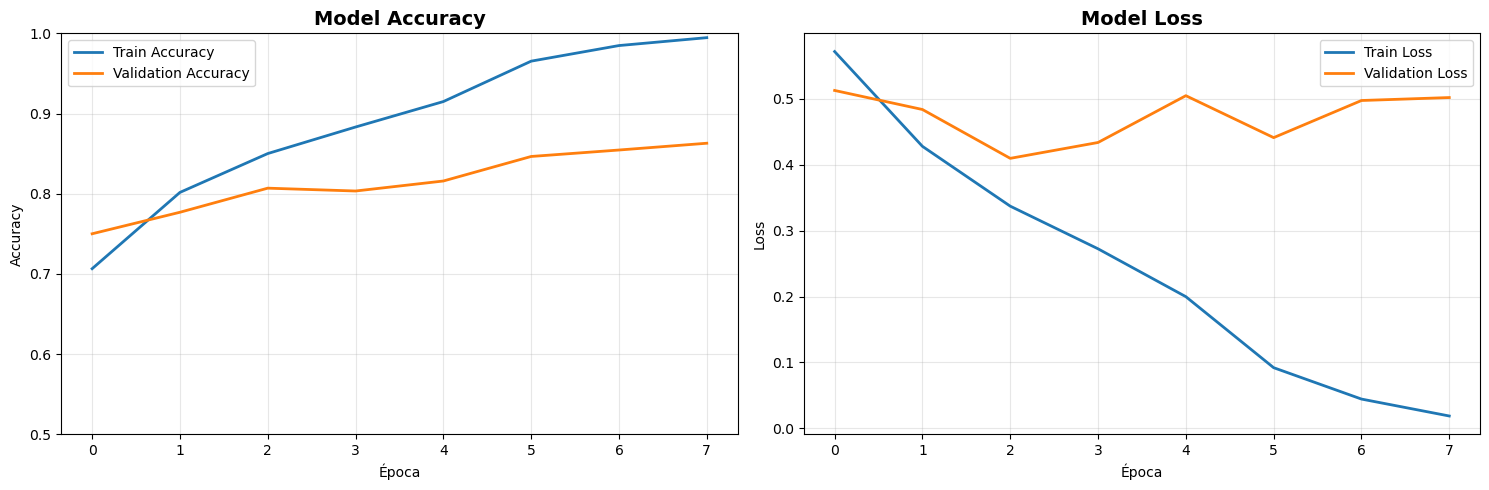

In [ ]:
# Crear gráficos de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Gráfico 2: Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Observaciones:**

- La precisión de entrenamiento alcanza el 99.38%, mientras que la de validación se queda en 86.29%. Esta diferencia de más del 13% indica que el modelo está memorizando los datos de entrenamiento en lugar de generalizar, lo que sugiere overfitting.

- Aunque la precisión de entrenamiento sigue mejorando dramáticamente, la de validación se estabiliza alrededor del 80-86% desde la época 3, lo que confirma el overfitting.

- La pérdida de validación deja de mejorar a partir del epoch 2 y se mantiene alrededor de 0.5, por lo que aún hay margen de mejora.

- Para mejorar el rendimiento en validación y reducir el overfitting, sería conveniente probar técnicas como Dropout y Data Augmentation.

Para tener un mejor control sobre la optimización, probaremos una mejora a la vez. Comenzaremos con Dropout (Del 25%, ya que es un valor moderado como punto de partida).

In [ ]:
from tensorflow.keras.layers import Dropout

model_v2 = Sequential()

# Bloque 1: 16 filtros
model_v2.add(Conv2D(16, (3, 3), activation='relu', input_shape=(112, 112, 3)))
model_v2.add(BatchNormalization())
model_v2.add(Dropout(0.25))
model_v2.add(MaxPooling2D(2, 2))

# Bloque 2: 32 filtros
model_v2.add(Conv2D(32, (3, 3), activation='relu'))
model_v2.add(BatchNormalization())
model_v2.add(Dropout(0.25))
model_v2.add(MaxPooling2D(2, 2))

# Bloque 3: 64 filtros
model_v2.add(Conv2D(64, (3, 3), activation='relu'))
model_v2.add(BatchNormalization())
model_v2.add(Dropout(0.25))
model_v2.add(MaxPooling2D(2, 2))

# Aplanar
model_v2.add(Flatten())

# Capas densas
model_v2.add(Dense(64, activation='relu'))
model_v2.add(Dropout(0.5))  # Dropout más fuerte en capas densas
model_v2.add(Dense(1, activation='sigmoid'))

model_v2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenar con los mismos callbacks y configuración
history_v2 = model_v2.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(df_train) // 32,
    validation_steps=len(df_val) // 32,
    epochs=8,
    callbacks=callbacks,  # Los mismos callbacks de antes
    verbose=1
)

Epoch 1/8


c:\Users\sergi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 156ms/step - accuracy: 0.6085 - loss: 0.7730 - val_accuracy: 0.6316 - val_loss: 0.7333 - learning_rate: 0.0010
Epoch 2/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.6823 - loss: 0.5788 - val_accuracy: 0.6095 - val_loss: 0.8778 - learning_rate: 0.0010
Epoch 3/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 157ms/step - accuracy: 0.7303 - loss: 0.5225 - val_accuracy: 0.5034 - val_loss: 3.3137 - learning_rate: 0.0010
Epoch 4/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 158ms/step - accuracy: 0.7724 - loss: 0.4574 - val_accuracy: 0.6757 - val_loss: 0.7103 - learning_rate: 5.0000e-04
Epoch 5/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 158ms/step - accuracy: 0.8067 - loss: 0.4078 - val_accuracy: 0.7675 - val_loss: 0.5249 - learning_rate: 5.0000e-04
Epoch 6/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 182ms/step - accuracy: 0.8256 - loss: 0.3764 - val_accuracy: 0.6979 - val_loss: 0.8274 - learning_rate: 5.0000e-04
Epoch 7/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 173ms/step - accuracy: 0.8375

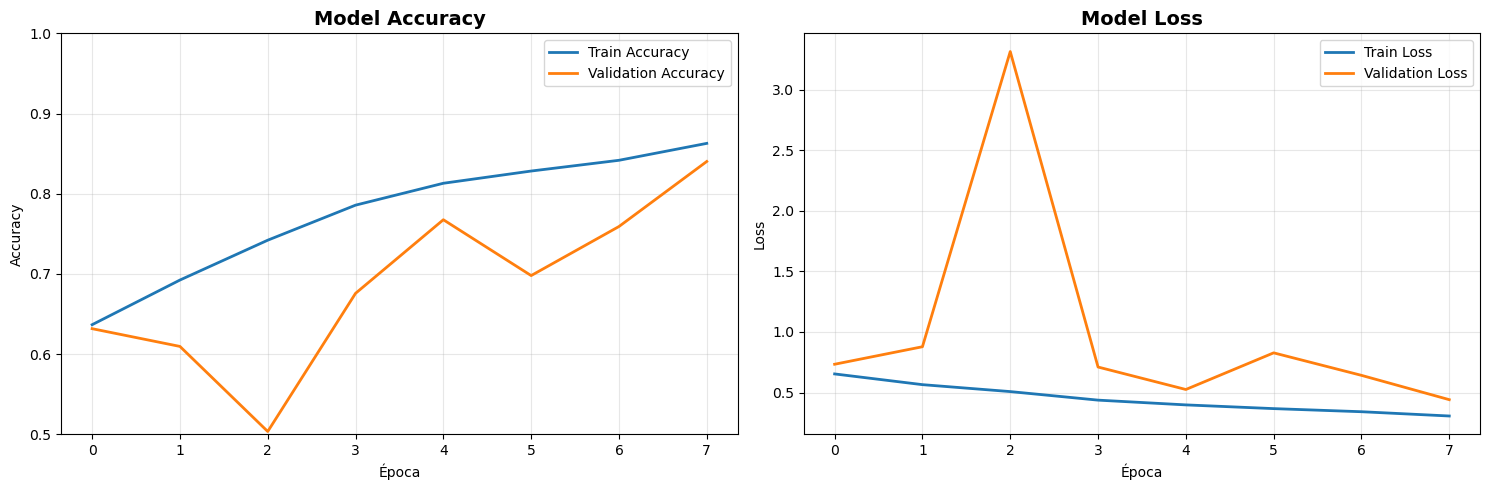

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Accuracy
axes[0].plot(history_v2.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_v2.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Gráfico 2: Loss
axes[1].plot(history_v2.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_v2.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Observaciones**

- El modelo con Dropout tiene una brecha mucho menor entre entrenamiento y validación (99% vs 86% antes, ahora 86% vs 84%), la regularización con Dropout evitó que el modelo memorice, promoviendo generalización.

- El val_loss bajó de 0.50 a 0.44, lo que sugiere que el nuevo modelo es más robusto y confiable

- El nuevo modelo mejora de forma constante hasta el último epoch, a diferencia del anterior que se estancó en el epoch 3.

Dropout fue efectivo. Aunque sacrificó algo de precisión en entrenamiento, mejoró la generalización y redujo claramente el overfitting. 

Ahora, ya que hay margen de mejroa, probaremos a aplicar data augmentation:

In [ ]:
# Data augmentation en el entrenamiento 
train_datagen_v3 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Crear generador con data augmentation en entrenamiento
gen_train_v3 = train_datagen_v3.flow_from_dataframe(
    df_train_str,
    directory='data/train/train', 
    x_col='filename',
    y_col='category',
    target_size=(112, 112),
    batch_size=32,
    class_mode='binary'
)

model_v3 = Sequential()

model_v3.add(Conv2D(16, (3, 3), activation='relu', input_shape=(112, 112, 3)))
model_v3.add(BatchNormalization())
model_v3.add(Dropout(0.25))
model_v3.add(MaxPooling2D(2, 2))

model_v3.add(Conv2D(32, (3, 3), activation='relu'))
model_v3.add(BatchNormalization())
model_v3.add(Dropout(0.25))
model_v3.add(MaxPooling2D(2, 2))

model_v3.add(Conv2D(64, (3, 3), activation='relu'))
model_v3.add(BatchNormalization())
model_v3.add(Dropout(0.25))
model_v3.add(MaxPooling2D(2, 2))

model_v3.add(Flatten())
model_v3.add(Dense(64, activation='relu'))
model_v3.add(Dropout(0.5))
model_v3.add(Dense(1, activation='sigmoid'))

model_v3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenar
history_v3 = model_v3.fit(
    gen_train_v3,
    validation_data=val_generator,
    steps_per_epoch=len(df_train) // 32,
    validation_steps=len(df_val) // 32,
    epochs=8,
    callbacks=callbacks,
    verbose=1
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


c:\Users\sergi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\sergi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 234ms/step - accuracy: 0.5709 - loss: 0.7857 - val_accuracy: 0.6072 - val_loss: 0.6272 - learning_rate: 0.0010
Epoch 2/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 228ms/step - accuracy: 0.6490 - loss: 0.6064 - val_accuracy: 0.7386 - val_loss: 0.5194 - learning_rate: 0.0010
Epoch 3/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 226ms/step - accuracy: 0.6987 - loss: 0.5616 - val_accuracy: 0.7095 - val_loss: 0.6471 - learning_rate: 0.0010
Epoch 4/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.7227 - loss: 0.5286 - val_accuracy: 0.7544 - val_loss: 0.6762 - learning_rate: 0.0010
Epoch 5/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.7518 - loss: 0.4963 - val_accuracy: 0.8051 - val_loss: 0.4201 - learning_rate: 5.0000e-04
Epoch 6/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 231ms/step - accuracy: 0.7679 - loss: 0.4646 - val_accuracy: 0.7953 - val_loss: 0.4370 - learning_rate: 5.0000e-04
Epoch 7/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 188s 301ms/step - accur

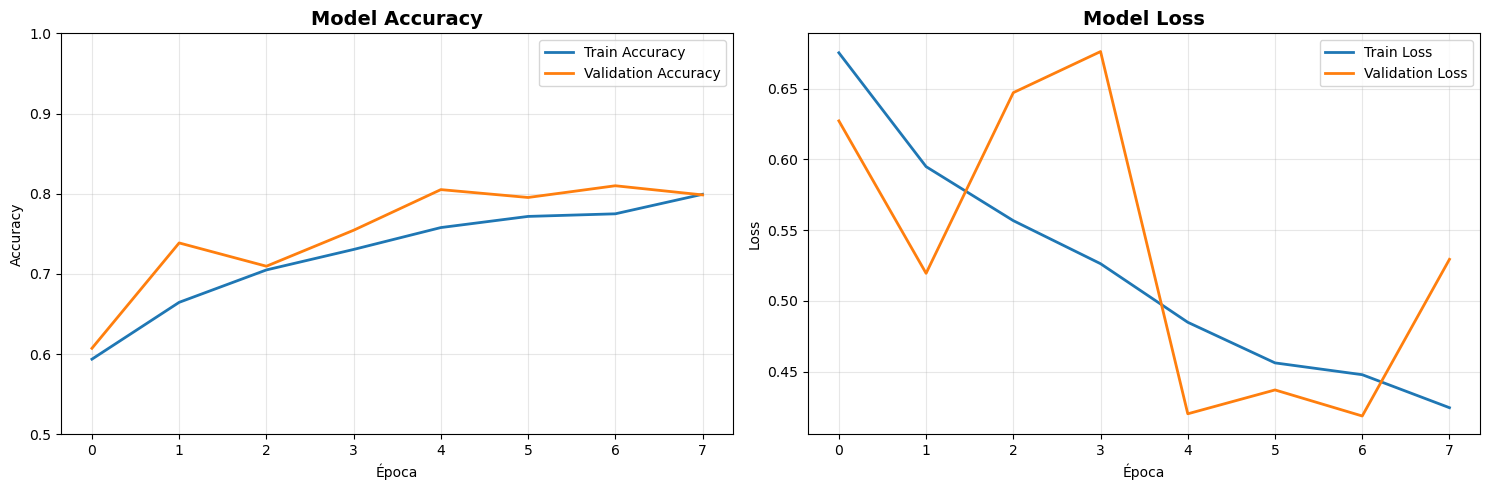

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Accuracy
axes[0].plot(history_v3.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_v3.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Gráfico 2: Loss
axes[1].plot(history_v3.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_v3.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Observaciones:**

- El modelo v2 (solo Dropout) obtuvo mejor desempeño absoluto (val_accuracy más alta y pérdida más baja).

- El modelo v3 (Dropout + Augmentation) mostró mejor regularización (menor brecha entre entrenamiento y validación) pero aprendió más lento.

- El augmentation pareció ayudar a evitar el overfitting, pero quizás fue un poco agresivo o mal calibrado en esta etapa.

En este punto, podríamos seguir mejorando el modelo ajustando hiperparámetros del augmentation, o aumentando la profundidad de la red (ya sea en las capas convolucionales o densas). Sin embargo, esto implicaría un mayor costo computacional y tiempos de entrenamiento más largos.

Por ello, una alternativa más eficiente y robusta es utilizar Transferencia de Aprendizaje

----

### **Transferencia de aprendizaje con ResNet50**

Optaremos por RestNet50, ya que es un modelo robusto y probado para clasificación binaria, especialmente con conjuntos de datos medianos, con una alta estabilidad y precisión

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D


# Preprocesamiento adaptado para ResNet50
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

gen_train_resnet = train_datagen_resnet.flow_from_dataframe(
    df_train_str,
    directory='data/train/train',
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

gen_val_resnet = val_datagen_resnet.flow_from_dataframe(
    df_val_str,
    directory='data/train/train',
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

print("Mapeo de clases:", gen_train_resnet.class_indices)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Mapeo de clases: {'cat': 0, 'dog': 1}


In [15]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Congelamos inicialmente

model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),  # Transferencia: tasa baja
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
model_resnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Podemos ver como ahora tenemos 23 millones de parametros y tan solo 262.000 entrenables

In [95]:
callbacks_resnet = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

In [ ]:
steps_per_epoch = len(df_train_str) // 64
validation_steps = len(df_val_str) // 64

history_resnet = model_resnet.fit(
    gen_train_resnet,
    validation_data=gen_val_resnet,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks_resnet,
    verbose=1
)

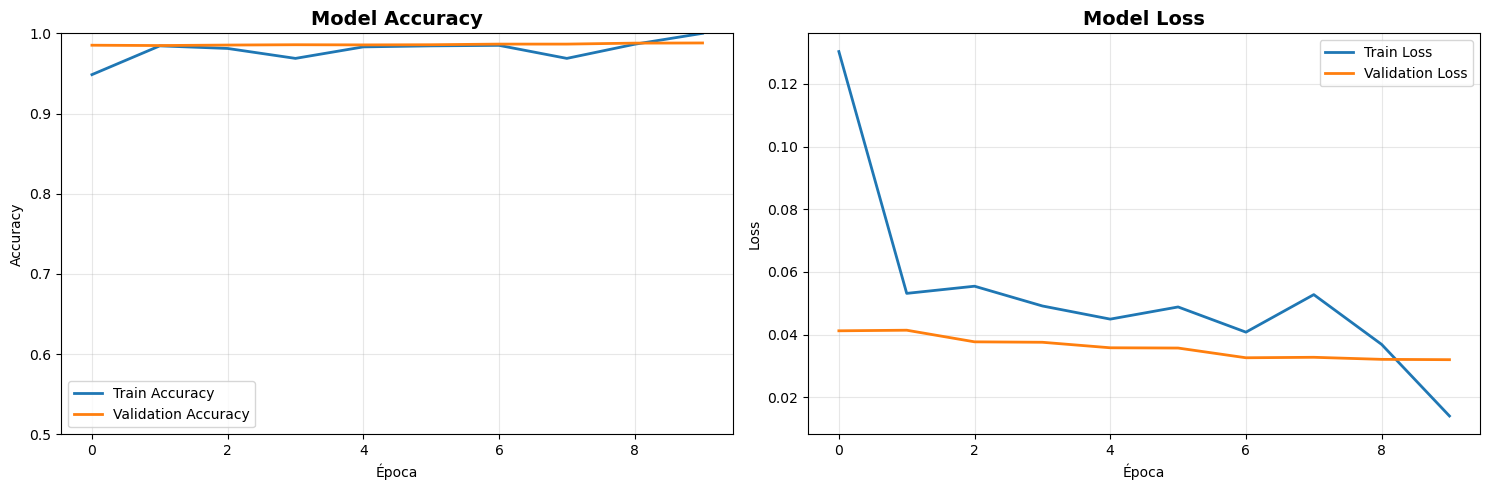

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Accuracy
axes[0].plot(history_resnet.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Gráfico 2: Loss
axes[1].plot(history_resnet.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_resnet.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Observaciones:**

- Muy alta precisión tanto en entrenamiento como en validación (≈ 98–99%), lo cual indica una muy buena capacidad de generalización.

- La loss de entrenamiento desciende de manera estable y clara y la loss de validación también disminuye ligeramente y se mantiene muy baja y estable, lo que indica que el modelo no se está sobreajustando y está aprendiendo patrones útiles.

## **Conclusiones finales**

- El primer modelo, el más sencillo, obtuvo buena precisión en entrenamiento, pero se sobreajustaba rápidamente. La precisión en validación era claramente inferior, lo que indicaba una baja capacidad de generalización.

- Con Dropout mejoró, especialmente en cuanto al overfitting, y logró mejores resultados que el modelo con data augmentation por sí solo.

- Aunque era posible seguir mejorando el modelo con más capas y combinaciones de data augmentation, dropout u otras técnicas, la transferencia de aprendizaje resultó ser lo más efectivo, ya que existen modelos muy sólidos ya entrenados que nos ahorran tiempo y recursos.

- ResNet50 ha demostrado ser un modelo extremadamente preciso y estable. Generaliza muy bien y no muestra signos de sobreajuste.